**Import Libraries and Mount To Google Drive To Get The Dataset**

In [1]:
#Reference 
#https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwju1MOJ8qv8AhWUSPEDHdoWDCkQFnoECA0QAQ&url=https%3A%2F%2Fmedium.com%2Fluca-chuangs-bapm-notes%2Fbuild-a-neural-network-in-python-regression-a80a906f634c&usg=AOvVaw0EJ1dJOGyoYU6aul8pNHCP

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data preprocessing
from sklearn.model_selection import train_test_split

# Neural Net modules
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import callbacks

from tensorflow.config.experimental import list_physical_devices

from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import os
import time
import gc
import random

In [2]:
print('GPU name: ', list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Connect to Google Drive to get datasets
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd MyDrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/MyDrive


**Prepare The Dataset**

In [4]:
class DatasetManager:
  def __init__(self):
    self.dataset_list = [s for s in os.listdir('AAML/') if s.endswith('.pkl')]

  def __del__(self):
    if self.x_train is None:
      return

    del self.x_train
    del self.x_test
    del self.y_train
    del self.y_test
    gc.collect()

  # Drop alpha values and just use RGB values
  def PrepareDatasetValuesRGB(self, index):
    if index >= len(self.dataset_list):
      print("Out of index")
      return

    print(f"Getting {self.dataset_list[index]}")
    dataframe = pd.read_pickle('AAML/' + self.dataset_list[index], compression='gzip')
    dataframe.drop(['top_left_a', 'top_a', 'top_right_a', 'left_a', 'right_a', 'bottom_left_a', 'bottom_a', 'bottom_right_a', 'middle_a'], axis=1, inplace=True)
    print(dataframe.info())

    Y = np.array(dataframe.iloc[:, 24:27])
    X = np.array(dataframe.iloc[:, 0:24])
    print(X.shape, Y.shape)

    del dataframe

    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, Y, test_size=0.3, random_state=6969)
    print(self.x_train.shape, self.x_test.shape, self.y_train.shape, self.y_test.shape)

    del X
    del Y
    gc.collect() 

  # Use with alpha values
  def PrepareDatasetValuesRGBA(self, index):
    if index >= len(self.dataset_list):
      print("Out of index")
      return

    print(f"Getting {self.dataset_list[index]}")
    dataframe = pd.read_pickle('AAML/' + self.dataset_list[index], compression='gzip')
    print(dataframe.info())
    Y = np.array(dataframe.iloc[:, 32:36])
    X = np.array(dataframe.iloc[:, 0:32])
    print(X.shape, Y.shape)

    del dataframe

    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, Y, test_size=0.3, random_state=6969)
    print(self.x_train.shape, self.x_test.shape, self.y_train.shape, self.y_test.shape)

    del X
    del Y
    gc.collect()

  def Reset(self):
    if self.x_train is None:
      return

    del self.x_train
    del self.x_test
    del self.y_train
    del self.y_test
    gc.collect()
  
  dataset_list = None
  x_train = x_test = y_train = y_test = None

**Train The Dataset**

In [5]:
# Used for loading, training and saving the model
class NNModel:
  def __init__(self, model_name="model", model_path=""):
    if os.path.exists(model_path):
      print(f"{model_path} is found | Loading the model ...")
      self.model = load_model(model_path)
      self.model_name = model_name
      return

    self.model_name = model_name

  def LoadModel(self, model):
    self.model = model

  def Summary(self):
    self.model.summary()

  def TrainModel(self, x_train, y_train, x_test, y_test, epochs=10):
    early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
    batch_size = round(x_train.shape[0] * 3.2142857142857142857142857142857e-5)
    self.history = self.model.fit(x_train, y_train, 
                                  validation_data=(x_test, y_test),
                                  callbacks=[early_stop],
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  verbose=1)
    
  def SaveModel(self, path):
    self.model.save(path)
      
  model = None
  history = None
  model_name = None

In [6]:
# Creating models with different optimizers and input values
# For testing if alpha value is needed or not
if os.path.exists('AAML/ADAM_RGBA') is False:
  new_model = Sequential()
  new_model._name = 'ADAM_RGBA'
  new_model.add(Dense(512, input_shape=(32,), activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(256, activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(128, activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(64, activation='relu'))
  new_model.add(Dense(4, activation='linear'))
  optimizer = Adam(epsilon=0.1)
  new_model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy', 'mae'])
  new_model.save('AAML/ADAM_RGBA')

if os.path.exists('AAML/ADAM_RGB') is False:
  new_model = Sequential()
  new_model._name = 'ADAM_RGB'
  new_model.add(Dense(512, input_shape=(24,), activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(256, activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(128, activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(64, activation='relu'))
  new_model.add(Dense(3, activation='linear'))
  optimizer = Adam(epsilon=0.1)
  new_model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy', 'mae'])
  new_model.save('AAML/ADAM_RGB')

"""
# It has already created with 'model' name
if os.path.exists('AAML/RMSPROP_RGBA') is False:
  new_model = Sequential()
  new_model._name = 'RMSPROP_RGBA'
  new_model.add(Dense(512, input_shape=(32,), activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(256, activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(128, activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(64, activation='relu'))
  new_model.add(Dense(4, activation='linear'))
  new_model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy', 'mae'])
  new_model.save('AAML/RMSPROP_RGBA')
"""

if os.path.exists('AAML/RMSPROP_RGB') is False:
  new_model = Sequential()
  new_model._name = 'RMSPROP_RGB'
  new_model.add(Dense(512, input_shape=(24,), activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(256, activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(128, activation='relu'))
  new_model.add(Dropout(0.5))
  new_model.add(Dense(64, activation='relu'))
  new_model.add(Dense(3, activation='linear'))
  new_model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy', 'mae'])
  new_model.save('AAML/RMSPROP_RGB')

In [7]:
model_path = 'AAML/model'
isRGBAModel = False

dataset_manager = DatasetManager()
dataset_count = len(dataset_manager.dataset_list)
print(f"Found {dataset_count} datasets ...")

index = random.randint(0, dataset_count - 1)

nn = NNModel(model_path=model_path)
if 'RGBA' in model_path or 'model' in model_path:
  dataset_manager.PrepareDatasetValuesRGBA(index)
  isRGBAModel = True
else:
  dataset_manager.PrepareDatasetValuesRGB(index)
nn.TrainModel(dataset_manager.x_train, dataset_manager.y_train, dataset_manager.x_test, dataset_manager.y_test, epochs=20)
nn.SaveModel(model_path)
dataset_manager.Reset()
del dataset_manager
gc.collect()

Found 5 datasets ...
AAML/model is found | Loading the model ...
Getting dataset_3.pkl
(40000000, 32) (40000000, 4)
(28000000, 32) (12000000, 32) (28000000, 4) (12000000, 4)
Epoch 1/20
31112/31112 [==============================] - 147s 5ms/step - loss: 376.6340 - mae: 11.9072 - val_loss: 463.2535 - val_mae: 14.0349
Epoch 2/20
31112/31112 [==============================] - 158s 5ms/step - loss: 366.4855 - mae: 11.7382 - val_loss: 445.7066 - val_mae: 13.8302
Epoch 3/20
31112/31112 [==============================] - 158s 5ms/step - loss: 358.8800 - mae: 11.6633 - val_loss: 489.4565 - val_mae: 14.5997
Epoch 4/20
31112/31112 [==============================] - 140s 5ms/step - loss: 361.5029 - mae: 11.7182 - val_loss: 507.8824 - val_mae: 14.9978
Epoch 5/20
31112/31112 [==============================] - 141s 5ms/step - loss: 358.9267 - mae: 11.6848 - val_loss: 619.9054 - val_mae: 15.2622
Epoch 6/20
31112/31112 [==============================] - 157s 5ms/step - loss: 368.3451 - mae: 11.7958 - 

0

**Make Predictions and Show That on Graphs**

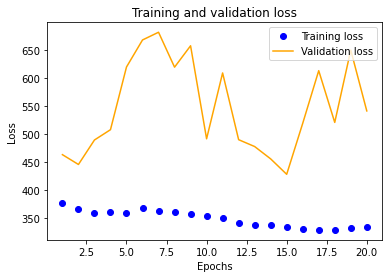

In [8]:
# let's see the training and validation accuracy by epoch
history_dict = nn.history.history
del nn
gc.collect()

loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test on The Image

In [9]:
class Timer: 
  
  def Start(self):
    self.start = time.perf_counter()

  def End(self, testName):
    self.end = time.perf_counter()
    print(f"{testName} : {self.end - self.start}")

  start = None
  end = None

In [10]:
def GetXNumpyArray(_list, rgba):
  ndArray = np.array(_list)
  ndArray = np.reshape(ndArray, (len(_list), 32)) if rgba else np.reshape(ndArray, (len(_list), 24))
  return ndArray

def GetPredictTupleList(predict_list):
  result_tuple = []
  for i in range(0, predict_list.shape[0]):
    result = predict_list[i]
    result = [round(pixel) for pixel in result]
    # if model is RGB, add 255 for alpha value
    if len(result) == 3:
      result.append(255)
    result_tuple.append(tuple(result))
  return result_tuple

class TestImage:
  def __init__(self, image_path):
    self.image_path = image_path

  def LoadImage(self):
    if self.image:
      self.image.close()

    self.image = Image.open(self.image_path)
    
    if self.image.mode == 'RGB':
      self.image = self.image.convert('RGBA')

    self.pixels = self.image.load()
    self.width = self.image.width
    self.height = self.image.height
    
  def __del__(self):
    if self.image:
      self.image.close()

  def SingleFullImage(self, model, rgba):
    self.LoadImage()
    self.DoTestWithFullImage(model, rgba=rgba)
    display(self.image)

  def SingleRowByRow(self, model, rgba):
    self.LoadImage()
    self.DoTestWithRowRow(model, rgba=rgba)
    display(self.image)

  def MultipleFullImage(self, model, count=2):
    self.LoadImage()
    for i in range(0, count):
      self.DoTestWithFullImage(model, verbose=0)
    display(self.image)

  def MultipleRowByRow(self, model, count=2):
    self.LoadImage()
    for i in range(0, count):
      self.DoTestWithRowRow(model)
    display(self.image)

  def GetPixelTupleRGB(self, pTuple):
    return_list = list(pTuple)
    return_list.pop()
    return tuple(return_list)

  def DoTestWithFullImage(self, model, rgba=False, verbose=1):
    pixelList = []
    to_predict = []

    for y in tqdm(range(1, self.height - 1), desc="Getting Pixel Values"):
      for x in range(1, self.width - 1):
        pixelList.extend(self.pixels[x - 1, y - 1] if rgba else self.GetPixelTupleRGB(self.pixels[x - 1, y - 1])) # top_left
        pixelList.extend(self.pixels[x    , y - 1] if rgba else self.GetPixelTupleRGB(self.pixels[x    , y - 1])) # top
        pixelList.extend(self.pixels[x + 1, y - 1] if rgba else self.GetPixelTupleRGB(self.pixels[x + 1, y - 1])) # top_right
        pixelList.extend(self.pixels[x - 1, y    ] if rgba else self.GetPixelTupleRGB(self.pixels[x - 1, y    ])) # left
        pixelList.extend(self.pixels[x + 1, y    ] if rgba else self.GetPixelTupleRGB(self.pixels[x + 1, y    ])) # right
        pixelList.extend(self.pixels[x - 1, y + 1] if rgba else self.GetPixelTupleRGB(self.pixels[x - 1, y + 1])) # bottom_left
        pixelList.extend(self.pixels[x    , y + 1] if rgba else self.GetPixelTupleRGB(self.pixels[x    , y + 1])) # bottom
        pixelList.extend(self.pixels[x + 1, y + 1] if rgba else self.GetPixelTupleRGB(self.pixels[x + 1, y + 1])) # bottom_right

        array = np.array(pixelList)

        to_predict.append(array)
        pixelList.clear()

    to_predict_nd = GetXNumpyArray(to_predict, rgba)
    predict = model.predict(to_predict_nd, verbose=verbose)
    result_tuple = GetPredictTupleList(predict)

    index = 0
    for y in tqdm(range(1, self.height - 1), desc="Writing Pixel Values"):
      for x in range(1, self.width - 1):
        self.pixels[x, y] = result_tuple[index]
        index = index + 1

  def DoTestWithRowRow(self, model, rgba=False):
    pixelList = []
    to_predict = []

    for y in tqdm(range(1, self.height - 1), desc="Predicting"):
      for x in range(1, self.width - 1):
        pixelList.extend(self.pixels[x - 1, y - 1] if rgba else self.GetPixelTupleRGB(self.pixels[x - 1, y - 1])) # top_left
        pixelList.extend(self.pixels[x    , y - 1] if rgba else self.GetPixelTupleRGB(self.pixels[x    , y - 1])) # top
        pixelList.extend(self.pixels[x + 1, y - 1] if rgba else self.GetPixelTupleRGB(self.pixels[x + 1, y - 1])) # top_right
        pixelList.extend(self.pixels[x - 1, y    ] if rgba else self.GetPixelTupleRGB(self.pixels[x - 1, y    ])) # left
        pixelList.extend(self.pixels[x + 1, y    ] if rgba else self.GetPixelTupleRGB(self.pixels[x + 1, y    ])) # right
        pixelList.extend(self.pixels[x - 1, y + 1] if rgba else self.GetPixelTupleRGB(self.pixels[x - 1, y + 1])) # bottom_left
        pixelList.extend(self.pixels[x    , y + 1] if rgba else self.GetPixelTupleRGB(self.pixels[x    , y + 1])) # bottom
        pixelList.extend(self.pixels[x + 1, y + 1] if rgba else self.GetPixelTupleRGB(self.pixels[x + 1, y + 1])) # bottom_right

        array = np.array(pixelList)
      
        to_predict.append(array)
        pixelList.clear()
    
      to_predict_nd = GetXNumpyArray(to_predict, rgba)
      predict = model.predict(to_predict_nd, verbose=0)
      result_tuple = GetPredictTupleList(predict)

      index = 0
      for i in range(1, self.width - 1):
        self.pixels[i, y] = result_tuple[index]
        index = index + 1

      to_predict.clear()

  image_path = None
  image = None
  pixels = None
  width = None
  height = None


Single Full Image ---------------------------------------------------------------


Getting Pixel Values:   0%|          | 0/375 [00:00<?, ?it/s]

6762/6762 [==============================] - 14s 2ms/step


Writing Pixel Values:   0%|          | 0/375 [00:00<?, ?it/s]

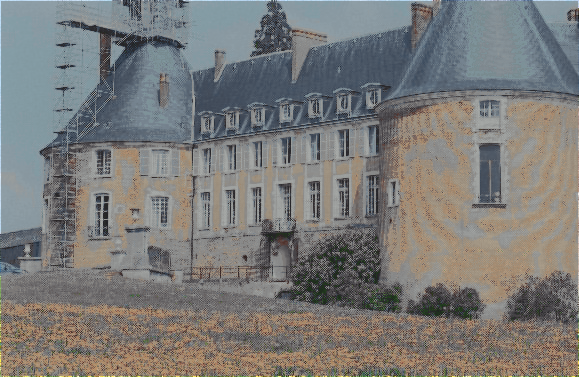

Single Row by Row ---------------------------------------------------------------


Predicting:   0%|          | 0/375 [00:00<?, ?it/s]

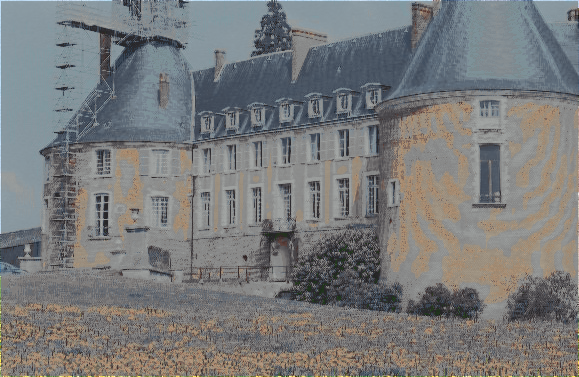

In [12]:
model = load_model(model_path)

test_image = TestImage('AAML/aliased.jpg')
print("Single Full Image ---------------------------------------------------------------")
test_image.SingleFullImage(model, rgba=isRGBAModel)
print("Single Row by Row ---------------------------------------------------------------")
test_image.SingleRowByRow(model, rgba=isRGBAModel)